In [1]:
import os
import cx_Oracle
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [2]:
def make_dataset(connection, attribute, catbat, region, sampling_prob = None):
    """
    Load the gc2_prediction_compare dataset for a given attribute and a given combination of catbat-region.
    
    Args:
        connection: list
            - user in position 0
            - password in position 1
            - database in position 2
        attribute: string
            Name of the attribute we want to test. The name must be the same as the column name in IMM_IMMEUBLE if the attribute
            is taken from that table. 
        catbat: string
            Building category(ies) we want to segment the dataset on
        region: int
            Region code(s) we want to segment the dataset on
        sampling_prob: float
            Sampling probability E[0, 1]
            
    Returns: panda DataFrame        
    """
    #Setup connection
    conn = cx_Oracle.connect(connection[0], connection[1], connection[2], encoding = 'utf-8')

    #Create query
    select_gc2_compare = """
                    SELECT   ID, im0.IMM_CAT_BAT as catbat,im0.IMM_NO_RA as RA, {0},
                    (SELECT {0} FROM IMM_IMMEUBLE WHERE IMM_NO_ID_UEF= COMP0) as comp0,
                    (SELECT {0} FROM IMM_IMMEUBLE WHERE IMM_NO_ID_UEF= COMP1) as COMP1, 
                    (SELECT {0} FROM IMM_IMMEUBLE WHERE IMM_NO_ID_UEF= COMP2) as COMP2 , 
                    (SELECT {0} FROM IMM_IMMEUBLE WHERE IMM_NO_ID_UEF= COMP3) as COMP3, 
                    (SELECT {0} FROM IMM_IMMEUBLE WHERE IMM_NO_ID_UEF= COMP4) as COMP4 , 
                    (SELECT {0} FROM IMM_IMMEUBLE WHERE IMM_NO_ID_UEF= COMP5) as COMP5 , 
                    (SELECT {0} FROM IMM_IMMEUBLE WHERE IMM_NO_ID_UEF= COMP6) as COMP6 , 
                    (SELECT {0} FROM IMM_IMMEUBLE WHERE IMM_NO_ID_UEF= COMP7) as COMP7 , 
                    (SELECT {0} FROM IMM_IMMEUBLE WHERE IMM_NO_ID_UEF= COMP8) as COMP8, 
                    (SELECT {0} FROM IMM_IMMEUBLE WHERE IMM_NO_ID_UEF= COMP9) as COMP9 , 
                    (SELECT {0} FROM IMM_IMMEUBLE WHERE IMM_NO_ID_UEF= COMP10) as COMP10 , 
                    (SELECT {0} FROM IMM_IMMEUBLE WHERE IMM_NO_ID_UEF= COMP11) as COMP11 , 
                    (SELECT {0} FROM IMM_IMMEUBLE WHERE IMM_NO_ID_UEF= COMP12) as COMP12 , 
                    (SELECT {0} FROM IMM_IMMEUBLE WHERE IMM_NO_ID_UEF= COMP13) as COMP13 , 
                    (SELECT {0} FROM IMM_IMMEUBLE WHERE IMM_NO_ID_UEF= COMP14) as COMP14 
                    FROM GC2_PREDICTION""".format(attribute)
    from_gc2_compare = """
                    JOIN IMM_IMMEUBLE im0 ON ID = im0.IMM_NO_ID_UEF
                    where im0.IMM_CAT_BAT in {0}
                    and im0.IMM_NO_RA = any{1}
                    """.format(catbat, region)

    if sampling_prob is not None:
        sample = "sample({})".format(int(float(sampling_prob) * 100))
        query_gc2_compare = "\n".join([select_gc2_compare, sample, from_gc2_compare])
    else:
        query_gc2_compare = "\n".join([select_gc2_compare, from_gc2_compare])

    #Convert dataset into df
    gc2_compare = pd.read_sql(query_gc2_compare, con = conn)
    
    #Remove row if attribute is missing or null
    #gc2_compare[attribute].replace(0, np.nan, inplace = True)
    #gc2_compare = gc2_compare.dropna(axis=0, subset=[attribute])
    #assert gc2_compare[attribute].isnull().sum() == 0, "There are missing values in the {} column".format(attribute)
   
    gc2_compare[attribute].replace(0, np.nan, inplace = True)
    gc2_compare.dropna(subset = [attribute], inplace = True)
    assert gc2_compare[attribute].isnull().sum() == 0, "There are missing values in the {} column".format(attribute)
    
    
    return gc2_compare


In [3]:
def num_metrics(df, attribute, catbat, region):
    """
    Compute a set of different metrics for numerical attributes.

    Args:
        df: pandas dataframe
            The dataset with the subject's ID and attribute, as well as all the comparants' attributes
        attribute: string
            Name of the attribute we want to test. The name must be the same as the column name in IMM_IMMEUBLE if the attribute
            is taken from that table.
        catbat: string
            Catbat category we are analyzing
        region: int
            Administrative region under analysis

    Returns a panda dataframe with the metrics computed for the given attribute, the avg percentile rank of the subject within the distribution,
            the avg number of zeros per obs (row), the avg number of nan values per obs (row), the catbat, the region and the number of obs.
    """
    def mae(row, attribute):
        """
        This function returns the mean absolute error (mae) of a specific row (i.e observation).
        y_true: the value of the subject's attribute for the attribute being tested
        y_pred: the values of the compabarables' attritube for the attribute being tested
        Note that the function is design to be use within the apply method.Thus we will not 'manually' input the required argument.

        Args:
            row: the row index. We don't have to fill that argument: the apply function will take care of it.
            attribute: string
            Name of the attribute we want to test. The name must be the same as the column name in IMM_IMMEUBLE if the attribut is taken from that table.
        """
        temp = []
        for col in df.columns[4:]:
            if (row[col] == 0 or np.isnan(row[col]) == True):
                continue
            else:
                temp.append(np.absolute(row[attribute] - row[col]))

        return np.mean(temp)

    def mape(row, attribute):
        """
        This function returns the mean absolute percentage error (mape) of a specific row (i.e observation).
        y_true: the value of the subject's attribute for the attribute being tested
        y_pred: the values of the compabarables' attritube for the attribute being tested
        Note that the function is design to be use within the apply method.Thus we will not 'manually' input the required argument.

        Args:
            row: the row index. We don't have to fill that argument: the apply function will take care of it.
            attribute: string
            Name of the attribute we want to test. The name must be the same as the column name in IMM_IMMEUBLE if the attribut is taken from that table.
        """
        temp2 = []
        for col in df.columns[4:]:
            if (row[col] == 0 or np.isnan(row[col]) == True):
                continue
            else:
                temp2.append((np.absolute((row[attribute] - row[col]) / row[attribute])))

        return (np.mean(temp2))*100

    def medape(row, attribute):
        """
        This function returns the median absolute percentage error (MedAPE) of a specific row (i.e observation).
        y_true: the value of the subject's attribute for the attribute being tested
        y_pred: the values of the compabarables' attritube for the attribute being tested
        Note that the function is design to be use within the apply method.Thus we will not 'manually' input the required argument.

        Args:
            row: the row index. We don't have to fill that argument: the apply function will take care of it.
            attribute: string
            Name of the attribute we want to test. The name must be the same as the column name in IMM_IMMEUBLE if the attribut is taken from that table.
        """
        temp3 = []
        for col in df.columns[4:]:
            if (row[col] == 0 or np.isnan(row[col]) == True):
                continue
            else:
                temp3.append((np.absolute((row[attribute] - row[col]) / row[attribute])))

        return (np.median(temp3))*100

    def percentileofscore(row):
        """
        This function returns the percentile rank of the subject's attribute value within the "distribution", i.e. the list 
            composed of the subject's value and its comparables'.
        The kind parameter is set at 'mean', which is the average of the 'weak' and 'strict' scores.    
        see :https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.percentileofscore.html
        Args:
            row: the row index. We don't have to fill that argument: the apply function will take care of it.
        """
        temp4 = []
        for col in df.columns[3:]:
            if (row[col] == 0 or np.isnan(row[col]) == True):
                continue
            else:
                temp4.append(row[col])
        return stats.percentileofscore(temp4,temp4[0], kind='mean')
    
    
#     metrics_N = pd.DataFrame(columns=['AVERAGE_MAE', 'AVERAGE_MAPE', 'AVERAGE_MEDAPE', 'cabat', 'Region', '#_obs'])
#     for reg in df.RA.unique():
#         df_temp = df[df['RA'] == reg]
#         met = pd.DataFrame(np.array([[round(df_temp.apply(mae, attribute = attribute, axis=1).mean(),3), round(df_temp.apply(mape, attribute = attribute, axis=1).mean(),3), round(df_temp.apply(medape, attribute = attribute, axis=1).mean(),3), catbat, reg, len(df_temp)]]), index=[attribute])
    
#         metrics_N = metrics_N.append(met)
    
    metrics_N = pd.DataFrame(np.array([[round(df.apply(mae, attribute = attribute, axis=1).mean(),3), round(df.apply(mape, attribute = attribute, axis=1).mean(),3), round(df.apply(medape, attribute = attribute, axis=1).mean(),3), round(df.apply(percentileofscore, axis=1).mean(),3), round((df.iloc[:,4:19] == 0).sum(axis=1).mean(),2), round(df.iloc[:,4:19].isna().sum(axis=1).mean(),2), catbat, region, len(df)]]), index=[attribute], columns=['AVG_MAE', 'AVG_MAPE', 'AVG_MEDAPE', 'AVG_pctl_rank', 'AVG_#_zeros', 'AVG_#_NAN','catbat', 'region', '#_obs'])
   

    return metrics_N

In [4]:
def transform_dataset(df, attribute):
    """
    Add columns of different metrics for numerical attributes.
    
    Args:
        df: pandas dataframe
            The dataset with the subject's ID and attribute, as well as all the comparants' attributes
        attribute: string
            Name of the attribute we want to test. The name must be the same as the column name in IMM_IMMEUBLE if the attribute
            is taken from that table.
    
    Returns a panda dataframe with the metrics computed for the given attribute.      
    """
    def mae(row, attribute):
        """
        This function returns the mean absolute error (mae) of a specific row (i.e observation).
        y_true: the value of the subject's attribute for the attribute being tested
        y_pred: the values of the compabarables' attritube for the attribute being tested
        Note that the function is design to be use within the apply method.Thus we will not 'manually' input the required argument.

        Args:
            row: the row index. We don't have to fill that argument: the apply function will take care of it.
            attribute: string
            Name of the attribute we want to test. The name must be the same as the column name in IMM_IMMEUBLE if the attribut is taken from that table.
        """
        temp = []
        for col in df.columns[4:19]:
            if (row[col] == 0 or np.isnan(row[col]) == True):
                continue
            else:
                temp.append(np.absolute(row[attribute] - row[col]))

        return np.mean(temp)

    def mape(row, attribute):
        """
        This function returns the mean absolute percentage error (mape) of a specific row (i.e observation).
        y_true: the value of the subject's attribute for the attribute being tested
        y_pred: the values of the compabarables' attritube for the attribute being tested
        Note that the function is design to be use within the apply method.Thus we will not 'manually' input the required argument.

        Args:
            row: the row index. We don't have to fill that argument: the apply function will take care of it.
            attribute: string
            Name of the attribute we want to test. The name must be the same as the column name in IMM_IMMEUBLE if the attribut is taken from that table.
        """
        temp2 = []
        for col in df.columns[4:19]:
            if (row[col] == 0 or np.isnan(row[col]) == True):
                continue
            else:
                temp2.append((np.absolute((row[attribute] - row[col]) / row[attribute])))

        return (np.mean(temp2))*100

    def medape(row, attribute):
        """
        This function returns the median absolute percentage error (MedAPE) of a specific row (i.e observation).
        y_true: the value of the subject's attribute for the attribute being tested
        y_pred: the values of the compabarables' attritube for the attribute being tested
        Note that the function is design to be use within the apply method.Thus we will not 'manually' input the required argument.

        Args:
            row: the row index. We don't have to fill that argument: the apply function will take care of it.
            attribute: string
            Name of the attribute we want to test. The name must be the same as the column name in IMM_IMMEUBLE if the attribut is taken from that table.
        """
        temp3 = []
        for col in df.columns[4:19]:
            if (row[col] == 0 or np.isnan(row[col]) == True):
                continue
            else:
                temp3.append((np.absolute((row[attribute] - row[col]) / row[attribute])))

        return (np.median(temp3))*100
    
    def percentileofscore(row):
        """
        This function returns the percentile rank of the subject's attribute value within the "distribution", i.e. of the list composed of the subject's value and its comparables'.
        """
        temp4 = []
        for col in df.columns[3:19]:
            if (row[col] == 0 or np.isnan(row[col]) == True):
                continue
            else:
                temp4.append(row[col])
        return stats.percentileofscore(temp4,temp4[0], kind='strict')

    

    df['MAE'] = df.apply(mae, attribute = attribute, axis=1)
    df['MAPE'] = df.apply(mape, attribute = attribute, axis=1)
    df['MedAPE'] = df.apply(medape, attribute = attribute, axis=1)
    df['#_NAN'] = df.iloc[:,4:19].isna().sum(axis=1)
    df['#_zeros'] = (df.iloc[:,4:19] == 0).sum(axis=1)
    df['pct_rank'] = df.apply(percentileofscore, axis=1)
    return df

In [52]:
#Liste de toutes les RA
#(1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17)
#liste de tous les catbat
#('2A', '3C', '2B', '2C')

## Attribute: Superficie

In [5]:
#créer un dataframe pour la superficie habitable
df_superf = make_dataset(connection=['jlr_website', '1qaz2wsx', 'jlrorap1relv'], attribute='IMM_SUPERF_BAT', catbat=('2A', '3C', '2B', '2C'), region=(1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17), sampling_prob=None)

In [6]:
##Condo
temp_superf_3C = df_superf[df_superf['CATBAT']=='3C']
pd.concat([pd.DataFrame(num_metrics(temp_superf_3C[(temp_superf_3C['RA']==reg)], 'IMM_SUPERF_BAT', catbat='3C', region=reg), columns=['AVG_MAE', 'AVG_MAPE', 'AVG_MEDAPE', 'AVG_pctl_rank', 'AVG_#_zeros', 'AVG_#_NAN','catbat', 'region', '#_obs']) for reg in range(1,18)],
           ignore_index=False)

C:\Users\estelle\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\estelle\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


AVG_MAE  AVG_MAPE AVG_MEDAPE AVG_pctl_rank AVG_#_zeros  \
IMM_SUPERF_BAT   85.261    45.169     32.085        48.419         0.0   
IMM_SUPERF_BAT   32.408    36.747     30.937         43.83        0.08   
IMM_SUPERF_BAT   40.579    42.709     34.847        48.557        0.18   
IMM_SUPERF_BAT   50.621  1173.378    1159.39        49.469         0.0   
IMM_SUPERF_BAT    56.83    55.311     36.954        47.138        0.16   
IMM_SUPERF_BAT   40.733    44.879     36.756        52.639        0.06   
IMM_SUPERF_BAT   31.058    38.775     33.412        47.386         0.0   
IMM_SUPERF_BAT   31.652    31.323     28.296        56.999         0.9   
IMM_SUPERF_BAT   36.041    39.936     27.629        29.508         0.0   
IMM_SUPERF_BAT   21.646    20.805     17.224         58.26         0.0   
IMM_SUPERF_BAT   47.715     35.19     30.034        58.294         0.0   
IMM_SUPERF_BAT   62.149    56.519     30.637        48.423         0.0   
IMM_SUPERF_BAT   30.223    31.707      27.37        51.801         0.0   
IMM_SUPERF_BAT   31.468  4923.481   4889.875        48.751        0.25   
IMM_SUPERF_BAT   41.609    59.898     53.198        50.716        0.42   
IMM_SUPERF_BAT   90.897   662.246    624.984        51.124         0.5   
IMM_SUPERF_BAT  167.328    37.952     35.919        50.637        0.21   

               AVG_#_NAN catbat region   #_obs  
IMM_SUPERF_BAT       2.8     3C      1    1272  
IMM_SUPERF_BAT      6.49     3C      2    2001  
IMM_SUPERF_BAT      5.43     3C      3   32546  
IMM_SUPERF_BAT      5.93     3C      4    1912  
IMM_SUPERF_BAT       4.3     3C      5    4211  
IMM_SUPERF_BAT      4.73     3C      6  122835  
IMM_SUPERF_BAT       3.3     3C      7   12545  
IMM_SUPERF_BAT       6.8     3C      8     258  
IMM_SUPERF_BAT      3.09     3C      9      92  
IMM_SUPERF_BAT      0.73     3C     10      11  
IMM_SUPERF_BAT       1.7     3C     11      20  
IMM_SUPERF_BAT      3.81     3C     12    5856  
IMM_SUPERF_BAT      5.07     3C     13   15694  
IMM_SUPERF_BAT      3.88     3C     14   11244  
IMM_SUPERF_BAT      8.35     3C     15    9658  
IMM_SUPERF_BAT      6.75     3C     16   37737  
IMM_SUPERF_BAT      5.72     3C     17     963

In [80]:
##Single-family home
#Create df
temp_superf_2A = df_superf[df_superf['CATBAT']=='2A']


In [81]:
#Perform metrics
pd.concat([pd.DataFrame(num_metrics(temp_superf_2A[(temp_superf_2A['RA']==reg)], 'IMM_SUPERF_BAT', catbat='2A', region=reg), columns=['AVG_MAE', 'AVG_MAPE', 'AVG_MEDAPE', 'AVG_pctl_rank', 'AVG_#_zeros', 'AVG_#_NAN','catbat', 'region', '#_obs']) for reg in range(1,18)],
         ignore_index=False)

AVG_MAE AVG_MAPE AVG_MEDAPE AVG_pctl_rank AVG_#_zeros  \
IMM_SUPERF_BAT  46.804   65.378     56.021        48.276         0.0   
IMM_SUPERF_BAT  41.311   37.836     29.282        48.059        0.71   
IMM_SUPERF_BAT  46.294   41.329     32.963        49.872        0.05   
IMM_SUPERF_BAT   46.45   83.342     71.084         45.89        0.25   
IMM_SUPERF_BAT  59.467   48.014     36.545        49.005        0.13   
IMM_SUPERF_BAT  79.306   50.843     39.483        50.713        0.38   
IMM_SUPERF_BAT   56.34    59.63     49.055        47.298        0.01   
IMM_SUPERF_BAT  42.898   53.245     45.016        48.923        0.02   
IMM_SUPERF_BAT   36.49    34.35     25.542        43.979         0.0   
IMM_SUPERF_BAT  25.939   25.221     21.875        53.721         0.0   
IMM_SUPERF_BAT  46.037   66.833     53.303        39.458        0.03   
IMM_SUPERF_BAT  50.397   49.108     40.209        49.225        0.09   
IMM_SUPERF_BAT  57.994   42.659     32.113        50.391         0.0   
IMM_SUPERF_BAT  53.637   72.333     57.257        47.244        0.19   
IMM_SUPERF_BAT  64.319   56.694     42.869        48.327        0.11   
IMM_SUPERF_BAT  60.132   95.491     78.769        49.797        0.16   
IMM_SUPERF_BAT   48.48   70.123     57.359        48.136        0.49   

               AVG_#_NAN catbat region   #_obs  
IMM_SUPERF_BAT      2.25     2A      1   41587  
IMM_SUPERF_BAT      2.72     2A      2   53256  
IMM_SUPERF_BAT      1.22     2A      3  137051  
IMM_SUPERF_BAT      2.38     2A      4   57726  
IMM_SUPERF_BAT      4.07     2A      5   53402  
IMM_SUPERF_BAT      0.65     2A      6  154268  
IMM_SUPERF_BAT      1.72     2A      7   92633  
IMM_SUPERF_BAT      2.04     2A      8   27012  
IMM_SUPERF_BAT      2.89     2A      9   18554  
IMM_SUPERF_BAT       1.2     2A     10    2650  
IMM_SUPERF_BAT      2.49     2A     11   15508  
IMM_SUPERF_BAT      2.45     2A     12   89710  
IMM_SUPERF_BAT      0.83     2A     13   88423  
IMM_SUPERF_BAT      1.57     2A     14  128496  
IMM_SUPERF_BAT      2.56     2A     15  142080  
IMM_SUPERF_BAT      1.95     2A     16  328770  
IMM_SUPERF_BAT      3.19     2A     17   47531

In [78]:
##Duplex
temp_superf_2B = df_superf[df_superf['CATBAT']=='2B']
d = pd.concat([pd.DataFrame(num_metrics(temp_superf_2B[(temp_superf_2B['RA']==reg)], 'IMM_SUPERF_BAT', catbat='2B', region=reg), columns=['AVG_MAE', 'AVG_MAPE', 'AVG_MEDAPE', 'AVG_pctl_rank', 'AVG_#_zeros', 'AVG_#_NAN','catbat', 'region', '#_obs']) for reg in range(1,18)],
         ignore_index=False)
duplex = d[d['#_obs'] != 0]
duplex

AVG_MAE AVG_MAPE AVG_MEDAPE AVG_pctl_rank AVG_#_zeros  \
IMM_SUPERF_BAT   35.942   31.876      26.61        57.692         0.0   
IMM_SUPERF_BAT   53.258   32.763     32.438         85.08        1.14   
IMM_SUPERF_BAT   61.301   37.679     33.506        68.188        0.05   
IMM_SUPERF_BAT   53.446   31.965     37.919        89.286         0.0   
IMM_SUPERF_BAT   62.428   34.476     34.702        72.418         0.0   
IMM_SUPERF_BAT  101.411   69.298      62.86        57.188        0.25   
IMM_SUPERF_BAT   58.289   40.954     35.518         55.61         0.0   
IMM_SUPERF_BAT   27.243   31.678     21.453        23.333         0.0   
IMM_SUPERF_BAT  179.105   60.231     59.583        94.365         0.0   
IMM_SUPERF_BAT  104.276   44.559     46.572        91.417         0.0   
IMM_SUPERF_BAT  108.346   45.558     49.213        87.143         0.0   
IMM_SUPERF_BAT   66.981    42.02     32.611        65.471         0.0   
IMM_SUPERF_BAT   61.005   47.763     37.909        48.539        0.21   
IMM_SUPERF_BAT   52.259   32.238     31.829        79.293        0.33   

               AVG_#_NAN catbat region #_obs  
IMM_SUPERF_BAT       3.0     2B      1     3  
IMM_SUPERF_BAT      2.14     2B      2     7  
IMM_SUPERF_BAT      1.13     2B      3   294  
IMM_SUPERF_BAT       2.0     2B      4     1  
IMM_SUPERF_BAT       3.4     2B      5     5  
IMM_SUPERF_BAT       1.0     2B      6     4  
IMM_SUPERF_BAT      0.62     2B      7     8  
IMM_SUPERF_BAT       1.0     2B      8     1  
IMM_SUPERF_BAT      1.33     2B     11     3  
IMM_SUPERF_BAT       3.0     2B     12     5  
IMM_SUPERF_BAT       1.4     2B     14     5  
IMM_SUPERF_BAT      3.25     2B     15    12  
IMM_SUPERF_BAT      1.58     2B     16    19  
IMM_SUPERF_BAT      3.33     2B     17     3

In [79]:
##Triplex
temp_superf_2C = df_superf[df_superf['CATBAT']=='2C']
t = pd.concat([pd.DataFrame(num_metrics(temp_superf_2C[(temp_superf_2C['RA']==reg)], 'IMM_SUPERF_BAT', catbat='2C', region=reg), columns=['AVG_MAE', 'AVG_MAPE', 'AVG_MEDAPE', 'AVG_pctl_rank', 'AVG_#_zeros', 'AVG_#_NAN','catbat', 'region', '#_obs']) for reg in range(1,18)],
         ignore_index=False)
triplex = t[t['#_obs'] != 0]
triplex

AVG_MAE AVG_MAPE AVG_MEDAPE AVG_pctl_rank AVG_#_zeros  \
IMM_SUPERF_BAT  114.114    49.81      55.74        96.667         0.0   
IMM_SUPERF_BAT   64.153   35.539     35.927        80.416        0.22   
IMM_SUPERF_BAT  160.155   99.617     92.152        52.917         0.5   
IMM_SUPERF_BAT   32.495   33.039     11.702         36.83        0.25   

               AVG_#_NAN catbat region #_obs  
IMM_SUPERF_BAT       1.0     2C      2     1  
IMM_SUPERF_BAT      1.22     2C      3     9  
IMM_SUPERF_BAT       2.0     2C      6     2  
IMM_SUPERF_BAT      0.75     2C     16     4

In [ ]:
x = np.arange(0,12)
y = df_superf_prime.groupby(['#_NAN']).MedAPE.mean()

fig, ax = plt.subplots()
ax.plot(x, y)

ax.set(xlabel='Number of NaN', ylabel='Moyenne MedAPE', title='Moyenne du MedAPE selon le # de NaN')
ax.grid()

plt.show()                              

## Attribute: Construction Year

In [82]:
#Create dataframe
df_an_const = make_dataset(connection=['jlr_website', '1qaz2wsx', 'jlrorap1relv'], attribute='IMM_AN_CONSTRUCTION', catbat=('2A', '3C', '2B', '2C'), region=(1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17), sampling_prob=None)

In [86]:
df_an_const.head()

ID CATBAT  RA  IMM_AN_CONSTRUCTION   COMP0   COMP1   COMP2   COMP3  \
4   1242703     2A   1               1974.0  1870.0  1975.0     NaN  1987.0   
5   1242753     2A   1               1972.0  1976.0  1967.0  2016.0  1830.0   
8   1246592     2A   1               1960.0  1991.0  1966.0  1987.0  1827.0   
9   1239738     2A   1               1874.0  2016.0  2007.0  1962.0  2012.0   
10  1239799     2A   1               1974.0  2016.0  2010.0  1962.0     NaN   

     COMP4   COMP5   COMP6   COMP7   COMP8   COMP9  COMP10  COMP11  COMP12  \
4   1978.0  2015.0  1968.0  1947.0  2007.0     NaN  1947.0  1973.0  2014.0   
5   1993.0  1936.0  2005.0  1866.0  1973.0     NaN  1978.0  1978.0  1965.0   
8   1966.0  1969.0  1973.0  1880.0     NaN  1993.0  1978.0  1982.0  2010.0   
9   1979.0  1994.0  1947.0  1976.0  2007.0     NaN  2003.0  1989.0  1987.0   
10  2018.0  1979.0  2007.0  1947.0  1920.0  1976.0  1962.0  2007.0  1910.0   

    COMP13  COMP14  
4      NaN  2010.0  
5   1955.0  1993.0  
8      NaN  1968.0  
9   1920.0  1962.0  
10  1974.0  2003.0

In [87]:
#Clean df
df_an_const = df_an_const[(df_an_const['IMM_AN_CONSTRUCTION'] >=1800) & (df_an_const['IMM_AN_CONSTRUCTION'] <= 2019)]


RA  IMM_AN_CONSTRUCTION         COMP0         COMP1  \
count  1.776365e+06         1.776365e+06  1.550247e+06  1.548764e+06   
mean   1.010270e+01         1.978735e+03  1.949517e+03  1.950014e+03   
std    5.226697e+00         2.691473e+01  2.499624e+02  2.489579e+02   
min    1.000000e+00         1.800000e+03  0.000000e+00  0.000000e+00   
25%    6.000000e+00         1.965000e+03  1.965000e+03  1.965000e+03   
50%    1.200000e+01         1.983000e+03  1.985000e+03  1.985000e+03   
75%    1.500000e+01         1.999000e+03  2.004000e+03  2.004000e+03   
max    1.700000e+01         2.019000e+03  2.201000e+03  2.201000e+03   

              COMP2         COMP3         COMP4         COMP5         COMP6  \
count  1.551642e+06  1.553849e+06  1.552856e+06  1.551380e+06  1.549689e+06   
mean   1.949810e+03  1.949504e+03  1.949781e+03  1.949536e+03  1.949806e+03   
std    2.499935e+02  2.511382e+02  2.499108e+02  2.510288e+02  2.501337e+02   
min    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
25%    1.965000e+03  1.965000e+03  1.965000e+03  1.965000e+03  1.965000e+03   
50%    1.986000e+03  1.985000e+03  1.985000e+03  1.986000e+03  1.986000e+03   
75%    2.004000e+03  2.004000e+03  2.004000e+03  2.004000e+03  2.004000e+03   
max    2.201000e+03  2.201000e+03  2.201000e+03  2.201000e+03  2.201000e+03   

              COMP7         COMP8         COMP9        COMP10        COMP11  \
count  1.550325e+06  1.547956e+06  1.547989e+06  1.549205e+06  1.548990e+06   
mean   1.948564e+03  1.949482e+03  1.949710e+03  1.950120e+03  1.949321e+03   
std    2.545391e+02  2.513876e+02  2.500964e+02  2.488292e+02  2.516850e+02   
min    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
25%    1.965000e+03  1.965000e+03  1.965000e+03  1.965000e+03  1.965000e+03   
50%    1.985000e+03  1.985000e+03  1.985000e+03  1.986000e+03  1.985000e+03   
75%    2.004000e+03  2.004000e+03  2.004000e+03  2.004000e+03  2.004000e+03   
max    2.201000e+03  2.201000e+03  2.201000e+03  2.201000e+03  2.201000e+03   

             COMP12        COMP13        COMP14  
count  1.549432e+06  1.550321e+06  1.550604e+06  
mean   1.949753e+03  1.949704e+03  1.950277e+03  
std    2.501335e+02  2.502597e+02  2.481735e+02  
min    0.000000e+00  0.000000e+00  0.000000e+00  
25%    1.965000e+03  1.965000e+03  1.965000e+03  
50%    1.985000e+03  1.985000e+03  1.985000e+03  
75%    2.004000e+03  2.004000e+03  2.004000e+03  
max    2.201000e+03  2.201000e+03  2.201000e+03

In [90]:
def annees_metrics(df, attribute, catbat, region):
    """
    Compute a set of different metrics for numerical attributes.

    Args:
        df: pandas dataframe
            The dataset with the subject's ID and attribute, as well as all the comparants' attributes
        attribute: string
            Name of the attribute we want to test. The name must be the same as the column name in IMM_IMMEUBLE if the attribute
            is taken from that table.
        catbat: string
            Catbat category we are analyzing
        region: int
            Administrative region under analysis

    Returns a panda dataframe with the metrics computed for the given attribute, the avg percentile rank of the subject within the distribution,
            the avg number of zeros per obs (row), the avg number of nan values per obs (row), the catbat, the region and the number of obs.
    """
    def mae(row, attribute):
        """
        This function returns the mean absolute error (mae) of a specific row (i.e observation).
        y_true: the value of the subject's attribute for the attribute being tested
        y_pred: the values of the compabarables' attritube for the attribute being tested
        Note that the function is design to be use within the apply method.Thus we will not 'manually' input the required argument.

        Args:
            row: the row index. We don't have to fill that argument: the apply function will take care of it.
            attribute: string
            Name of the attribute we want to test. The name must be the same as the column name in IMM_IMMEUBLE if the attribut is taken from that table.
        """
        temp = []
        for col in df.columns[4:]:
            if (row[col] < 1800 or row[col] > 2019 or np.isnan(row[col]) == True):
                continue
            else:
                temp.append(np.absolute(row[attribute] - row[col]))

        return np.mean(temp)

    def mape(row, attribute):
        """
        This function returns the mean absolute percentage error (mape) of a specific row (i.e observation).
        y_true: the value of the subject's attribute for the attribute being tested
        y_pred: the values of the compabarables' attritube for the attribute being tested
        Note that the function is design to be use within the apply method.Thus we will not 'manually' input the required argument.

        Args:
            row: the row index. We don't have to fill that argument: the apply function will take care of it.
            attribute: string
            Name of the attribute we want to test. The name must be the same as the column name in IMM_IMMEUBLE if the attribut is taken from that table.
        """
        temp2 = []
        for col in df.columns[4:]:
            if (row[col] < 1800 or row[col] > 2019 or np.isnan(row[col]) == True):
                continue
            else:
                temp2.append((np.absolute((row[attribute] - row[col]) / row[attribute])))

        return (np.mean(temp2))*100

    def medape(row, attribute):
        """
        This function returns the median absolute percentage error (MedAPE) of a specific row (i.e observation).
        y_true: the value of the subject's attribute for the attribute being tested
        y_pred: the values of the compabarables' attritube for the attribute being tested
        Note that the function is design to be use within the apply method.Thus we will not 'manually' input the required argument.

        Args:
            row: the row index. We don't have to fill that argument: the apply function will take care of it.
            attribute: string
            Name of the attribute we want to test. The name must be the same as the column name in IMM_IMMEUBLE if the attribut is taken from that table.
        """
        temp3 = []
        for col in df.columns[4:]:
            if (row[col] < 1800 or row[col] > 2019 or np.isnan(row[col]) == True):
                continue
            else:
                temp3.append((np.absolute((row[attribute] - row[col]) / row[attribute])))

        return (np.median(temp3))*100

    def percentileofscore(row):
        """
        This function returns the percentile rank of the subject's attribute value within the "distribution", i.e. the list 
            composed of the subject's value and its comparables'.
        The kind parameter is set at 'mean', which is the average of the 'weak' and 'strict' scores.    
        see :https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.percentileofscore.html
        Args:
            row: the row index. We don't have to fill that argument: the apply function will take care of it.
        """
        temp4 = []
        for col in df.columns[3:]:
            if (row[col] < 1800 or row[col] > 2019 or np.isnan(row[col]) == True):
                continue
            else:
                temp4.append(row[col])
        return stats.percentileofscore(temp4,temp4[0], kind='mean')
    
    
#     metrics_N = pd.DataFrame(columns=['AVERAGE_MAE', 'AVERAGE_MAPE', 'AVERAGE_MEDAPE', 'cabat', 'Region', '#_obs'])
#     for reg in df.RA.unique():
#         df_temp = df[df['RA'] == reg]
#         met = pd.DataFrame(np.array([[round(df_temp.apply(mae, attribute = attribute, axis=1).mean(),3), round(df_temp.apply(mape, attribute = attribute, axis=1).mean(),3), round(df_temp.apply(medape, attribute = attribute, axis=1).mean(),3), catbat, reg, len(df_temp)]]), index=[attribute])
    
#         metrics_N = metrics_N.append(met)
    
    metrics_N = pd.DataFrame(np.array([[round(df.apply(mae, attribute = attribute, axis=1).mean(),3), round(df.apply(mape, attribute = attribute, axis=1).mean(),3), round(df.apply(medape, attribute = attribute, axis=1).mean(),3), round(df.apply(percentileofscore, axis=1).mean(),3), round(((df.iloc[:,4:19] < 1800) or (df.iloc[:,4:19] > 2019)).sum(axis=1).mean(),2), round(df.iloc[:,4:19].isna().sum(axis=1).mean(),2), catbat, region, len(df)]]), index=[attribute], columns=['AVG_MAE', 'AVG_MAPE', 'AVG_MEDAPE', 'AVG_pctl_rank', 'AVG_#_zeros', 'AVG_#_NAN','catbat', 'region', '#_obs'])
   

    return metrics_N


In [94]:
##Condo
temp_const_3C = df_an_const[df_an_const['CATBAT']=='3C']
pd.concat([pd.DataFrame(num_metrics(temp_const_3C[(temp_const_3C['RA']==reg)], 'IMM_AN_CONSTRUCTION', catbat='3C', region=reg), columns=['AVG_MAE', 'AVG_MAPE', 'AVG_MEDAPE', 'AVG_pctl_rank', 'AVG_#_zeros', 'AVG_#_NAN','catbat', 'region', '#_obs']) for reg in range(1,18)],
         ignore_index=False)


AVG_MAE AVG_MAPE AVG_MEDAPE AVG_pctl_rank AVG_#_zeros  \
IMM_AN_CONSTRUCTION  16.686    0.839      0.801        47.885         0.0   
IMM_AN_CONSTRUCTION  14.519    0.729      0.711         43.89         0.0   
IMM_AN_CONSTRUCTION  27.088    1.373      1.086        44.455        0.05   
IMM_AN_CONSTRUCTION  16.361    0.826      0.802        33.976         0.0   
IMM_AN_CONSTRUCTION  13.994    0.703      0.666        42.933         0.0   
IMM_AN_CONSTRUCTION  32.656     1.66      1.352         46.39        0.02   
IMM_AN_CONSTRUCTION  15.196    0.762      0.745        47.475        0.07   
IMM_AN_CONSTRUCTION  16.174    0.815      0.795         40.93         0.0   
IMM_AN_CONSTRUCTION  24.717    1.237      1.235        76.996         0.0   
IMM_AN_CONSTRUCTION  29.561    1.473      1.433        83.299         0.0   
IMM_AN_CONSTRUCTION  32.006      1.6      1.352        80.455         0.0   
IMM_AN_CONSTRUCTION  15.462    0.779      0.676        45.991         0.0   
IMM_AN_CONSTRUCTION  12.652    0.634      0.599        43.759        0.02   
IMM_AN_CONSTRUCTION  12.101    0.606      0.487        43.859        0.21   
IMM_AN_CONSTRUCTION  12.483    0.625      0.501        42.601        1.47   
IMM_AN_CONSTRUCTION  15.152    0.761      0.629        43.398        0.43   
IMM_AN_CONSTRUCTION   13.07    0.656      0.651        38.363        0.09   

                    AVG_#_NAN catbat region   #_obs  
IMM_AN_CONSTRUCTION      0.35     3C      1    1482  
IMM_AN_CONSTRUCTION      4.57     3C      2    2186  
IMM_AN_CONSTRUCTION      4.79     3C      3   35571  
IMM_AN_CONSTRUCTION      5.48     3C      4    2265  
IMM_AN_CONSTRUCTION      1.91     3C      5    4945  
IMM_AN_CONSTRUCTION      4.07     3C      6  129130  
IMM_AN_CONSTRUCTION      2.62     3C      7   12670  
IMM_AN_CONSTRUCTION      0.92     3C      8     401  
IMM_AN_CONSTRUCTION      0.91     3C      9     119  
IMM_AN_CONSTRUCTION       4.3     3C     10      33  
IMM_AN_CONSTRUCTION      0.85     3C     11      20  
IMM_AN_CONSTRUCTION      2.99     3C     12    6279  
IMM_AN_CONSTRUCTION      3.12     3C     13   20282  
IMM_AN_CONSTRUCTION      3.25     3C     14   12978  
IMM_AN_CONSTRUCTION       4.1     3C     15   16820  
IMM_AN_CONSTRUCTION       4.3     3C     16   50046  
IMM_AN_CONSTRUCTION      2.81     3C     17    1258

In [95]:
##Single-family
temp_const_2A = df_an_const[df_an_const['CATBAT']=='2A']
pd.concat([pd.DataFrame(num_metrics(temp_const_2A[(temp_const_2A['RA']==reg)], 'IMM_AN_CONSTRUCTION', catbat='2A', region=reg), columns=['AVG_MAE', 'AVG_MAPE', 'AVG_MEDAPE', 'AVG_pctl_rank', 'AVG_#_zeros', 'AVG_#_NAN','catbat', 'region', '#_obs']) for reg in range(1,18)],
         ignore_index=False)

AVG_MAE AVG_MAPE AVG_MEDAPE AVG_pctl_rank AVG_#_zeros  \
IMM_AN_CONSTRUCTION  35.449    1.816      1.639         43.68        0.09   
IMM_AN_CONSTRUCTION  25.839    1.313      1.204        44.013         0.0   
IMM_AN_CONSTRUCTION   27.52      1.4      1.253        44.249        0.01   
IMM_AN_CONSTRUCTION  29.022    1.482      1.296        43.382        0.12   
IMM_AN_CONSTRUCTION  33.012    1.685      1.554        40.896        0.03   
IMM_AN_CONSTRUCTION  29.453    1.502      1.338        52.427        0.01   
IMM_AN_CONSTRUCTION  25.795    1.308      1.207        44.377        0.33   
IMM_AN_CONSTRUCTION  25.209     1.28      1.183        45.477         0.0   
IMM_AN_CONSTRUCTION  20.438    1.037      0.923        49.196         0.0   
IMM_AN_CONSTRUCTION  16.127    0.816      0.693        51.264         0.0   
IMM_AN_CONSTRUCTION  33.447    1.715      1.545        44.137         0.0   
IMM_AN_CONSTRUCTION  36.005    1.842      1.571        42.913        0.04   
IMM_AN_CONSTRUCTION  22.263    1.127      1.051        50.219         0.0   
IMM_AN_CONSTRUCTION  23.451     1.19      1.101        43.175        0.08   
IMM_AN_CONSTRUCTION  25.435    1.289      1.168        45.007        1.46   
IMM_AN_CONSTRUCTION  26.903    1.367      1.236        45.914        0.12   
IMM_AN_CONSTRUCTION  30.455    1.552      1.412        43.849        0.57   

                    AVG_#_NAN catbat region   #_obs  
IMM_AN_CONSTRUCTION      1.66     2A      1   38908  
IMM_AN_CONSTRUCTION      1.85     2A      2   56903  
IMM_AN_CONSTRUCTION      1.09     2A      3  138923  
IMM_AN_CONSTRUCTION      1.82     2A      4   59692  
IMM_AN_CONSTRUCTION      1.98     2A      5   58207  
IMM_AN_CONSTRUCTION      0.47     2A      6  158862  
IMM_AN_CONSTRUCTION      1.36     2A      7   89290  
IMM_AN_CONSTRUCTION      1.82     2A      8   27389  
IMM_AN_CONSTRUCTION      0.71     2A      9   20101  
IMM_AN_CONSTRUCTION      3.15     2A     10    2080  
IMM_AN_CONSTRUCTION      1.45     2A     11   15638  
IMM_AN_CONSTRUCTION      2.45     2A     12   87283  
IMM_AN_CONSTRUCTION      0.51     2A     13   88931  
IMM_AN_CONSTRUCTION      1.55     2A     14  126942  
IMM_AN_CONSTRUCTION      1.89     2A     15  128619  
IMM_AN_CONSTRUCTION      1.66     2A     16  335073  
IMM_AN_CONSTRUCTION       2.7     2A     17   46638

In [92]:
##Duplex
temp_const_2B = df_an_const[df_an_const['CATBAT']=='2B']
da = pd.concat([pd.DataFrame(num_metrics(temp_const_2B[(temp_const_2B['RA']==reg)], 'IMM_AN_CONSTRUCTION', catbat='2B', region=reg), columns=['AVG_MAE', 'AVG_MAPE', 'AVG_MEDAPE', 'AVG_pctl_rank', 'AVG_#_zeros', 'AVG_#_NAN','catbat', 'region', '#_obs']) for reg in range(1,18)],
         ignore_index=False)
duplexa = da[da['#_obs'] != 0]
duplexa

AVG_MAE AVG_MAPE AVG_MEDAPE AVG_pctl_rank AVG_#_zeros  \
IMM_AN_CONSTRUCTION  37.444    1.929      1.901        34.341        0.33   
IMM_AN_CONSTRUCTION    37.5    1.934      1.895        11.118         0.0   
IMM_AN_CONSTRUCTION  32.374     1.66      1.514        31.752         0.0   
IMM_AN_CONSTRUCTION  35.692    1.807      1.646          50.0         0.0   
IMM_AN_CONSTRUCTION  35.629     1.84      1.618        40.198         0.0   
IMM_AN_CONSTRUCTION  64.367    3.364      3.309        28.237         0.0   
IMM_AN_CONSTRUCTION  22.937    1.152      1.011        58.132        0.22   
IMM_AN_CONSTRUCTION  35.429    1.818      1.719          10.0         0.0   
IMM_AN_CONSTRUCTION   7.071    0.358      0.253        86.667         0.0   
IMM_AN_CONSTRUCTION  30.594    1.563      1.464        47.222         0.0   
IMM_AN_CONSTRUCTION  40.499    2.086      2.205        26.956         0.0   
IMM_AN_CONSTRUCTION  23.881     1.21      1.167        29.365         0.0   
IMM_AN_CONSTRUCTION  20.502    1.027      0.936        54.543        1.62   
IMM_AN_CONSTRUCTION  35.271    1.802      1.599        40.529        0.24   
IMM_AN_CONSTRUCTION  28.399    1.425      1.657        57.917         0.5   

                    AVG_#_NAN catbat region #_obs  
IMM_AN_CONSTRUCTION      2.33     2B      1     3  
IMM_AN_CONSTRUCTION       1.5     2B      2     8  
IMM_AN_CONSTRUCTION      1.01     2B      3   295  
IMM_AN_CONSTRUCTION       2.0     2B      4     2  
IMM_AN_CONSTRUCTION      1.67     2B      5     6  
IMM_AN_CONSTRUCTION       0.5     2B      6     4  
IMM_AN_CONSTRUCTION      0.78     2B      7     9  
IMM_AN_CONSTRUCTION       1.0     2B      8     1  
IMM_AN_CONSTRUCTION       1.0     2B      9     1  
IMM_AN_CONSTRUCTION      0.33     2B     11     3  
IMM_AN_CONSTRUCTION       2.0     2B     12     5  
IMM_AN_CONSTRUCTION       1.5     2B     14     6  
IMM_AN_CONSTRUCTION      1.56     2B     15    16  
IMM_AN_CONSTRUCTION      1.43     2B     16    21  
IMM_AN_CONSTRUCTION       2.0     2B     17     2

In [96]:
##Triplex
temp_const_2C = df_an_const[df_an_const['CATBAT']=='2C']
ta = pd.concat([pd.DataFrame(num_metrics(temp_const_2C[(temp_const_2C['RA']==reg)], 'IMM_AN_CONSTRUCTION', catbat='2C', region=reg), columns=['AVG_MAE', 'AVG_MAPE', 'AVG_MEDAPE', 'AVG_pctl_rank', 'AVG_#_zeros', 'AVG_#_NAN','catbat', 'region', '#_obs']) for reg in range(1,18)],
         ignore_index=False)
triplexa = ta[ta['#_obs'] != 0]
triplexa

AVG_MAE AVG_MAPE AVG_MEDAPE AVG_pctl_rank AVG_#_zeros  \
IMM_AN_CONSTRUCTION  40.267    2.071      2.212         9.375         0.0   
IMM_AN_CONSTRUCTION  27.677    1.413      1.325        21.469         0.0   
IMM_AN_CONSTRUCTION  55.542    2.892      3.059        26.683         0.0   
IMM_AN_CONSTRUCTION  32.801    1.679      1.593        19.827        0.14   

                    AVG_#_NAN catbat region #_obs  
IMM_AN_CONSTRUCTION       0.0     2C      2     1  
IMM_AN_CONSTRUCTION      1.11     2C      3     9  
IMM_AN_CONSTRUCTION       1.5     2C      6     2  
IMM_AN_CONSTRUCTION      1.29     2C     16     7

## Attribute: Municipal assessment (total)

In [5]:
#create df
df_eval = make_dataset(connection=['jlr_website', '1qaz2wsx', 'jlrorap1relv'], attribute='IMM_VALEUR_TOT', catbat=('2A', '3C', '2B', '2C'), region=(1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17), sampling_prob=None)

In [98]:
df_eval.groupby(['CATBAT', 'RA']).IMM_VALEUR_TOT.describe()

count           mean           std       min       25%  \
CATBAT RA                                                              
2A     1    41472.0  155971.934558  9.145063e+04     100.0   96300.0   
       2    59302.0  173837.917861  1.068524e+05     100.0  130000.0   
       3   139231.0  279385.797667  4.856792e+05      10.0  215000.0   
       4    60641.0  152403.739764  1.091037e+05     100.0  110500.0   
       5    47891.0  240150.538598  5.725332e+06     100.0  147700.0   
       6   159324.0  505492.328099  5.177587e+05       2.0  314600.0   
       7    94359.0  243036.536038  1.222181e+05     100.0  178500.0   
       8    23948.0  197940.243444  1.030750e+05     500.0  133500.0   
       9    19057.0  162176.053261  2.445051e+05      27.0  100400.0   
       10    2653.0  128266.679231  6.705451e+04    1200.0   78500.0   
       11   13899.0  119865.904741  7.919537e+04     100.0   74160.0   
       12   89230.0  210359.415555  1.745153e+05     100.0  126100.0   
       13   89668.0  333937.885979  1.742071e+05     100.0  259700.0   
       14  131010.0  225131.987825  1.649926e+05     100.0  161500.0   
       15  153804.0  259505.581955  1.639709e+05     100.0  178500.0   
       16  344349.0  283677.509623  2.715759e+05      10.0  204000.0   
       17   52920.0  166006.958787  3.659321e+05     100.0  114500.0   
2B     1        3.0  116400.000000  2.381953e+04   93700.0  104000.0   
       2        8.0  185725.000000  7.782504e+04  126100.0  136625.0   
       3      297.0  368787.616162  1.452160e+05   79600.0  279000.0   
       4        2.0  221500.000000  1.223295e+05  135000.0  178250.0   
       5        5.0  397480.000000  1.974146e+05  240900.0  270200.0   
       6        4.0  387150.000000  9.542992e+04  312100.0  338875.0   
       7        9.0  254777.777778  8.706105e+04  110300.0  177900.0   
       8        1.0  147100.000000           NaN  147100.0  147100.0   
       9        1.0  182400.000000           NaN  182400.0  182400.0   
       11       3.0  216300.000000  7.598375e+04  133900.0  182650.0   
       12       5.0  361940.000000  1.515578e+05  140200.0  290000.0   
       14       7.0  253071.428571  1.298681e+05  111100.0  150050.0   
       15      18.0  271600.000000  1.310306e+05   53000.0  185975.0   
       16      21.0  295133.333333  1.205271e+05   84000.0  217100.0   
       17       4.0  174800.000000  7.473932e+04  107400.0  124425.0   
2C     2        1.0  143600.000000           NaN  143600.0  143600.0   
       3       10.0  347000.000000  7.009834e+04  268000.0  303250.0   
       6        2.0  459300.000000  2.302340e+05  296500.0  377900.0   
       16       9.0  312277.777778  1.811953e+05  163000.0  184800.0   
3C     1     1469.0  176472.246426  1.148119e+05   15700.0  128000.0   
       2     2364.0  157277.923012  6.091282e+04    1400.0  130475.0   
       3    35993.0  236664.713944  2.900985e+05    1400.0  167000.0   
       4     2360.0  141605.096610  1.847944e+05    4028.0  108000.0   
       5     4665.0  199312.336549  3.231180e+05     100.0  136200.0   
       6   133372.0  321427.005496  3.276306e+05     500.0  213600.0   
       7    12768.0  191145.402569  1.238105e+05    6000.0  139375.0   
       8      391.0  189972.122762  5.646985e+04     400.0  157250.0   
       9      127.0  181722.834646  6.006696e+04   16400.0  131300.0   
       10      14.0  132621.428571  5.567691e+04   65500.0   83250.0   
       11      10.0  162611.000000  5.062864e+04   61810.0  137867.5   
       12    6386.0  204231.929220  1.219395e+05     100.0  146500.0   
       13   18643.0  251510.273025  4.487845e+05    1500.0  187000.0   
       14   14460.0  186759.141909  8.504483e+04       1.0  146600.0   
       15   19980.0  214831.910210  1.379340e+05     100.0  155600.0   
       16   56528.0  214538.811332  1.901834e+05     100.0  160800.0   
       17    1316.0  219112.568389  4.028471e+05    2600.0  119150.0   

                50%       75%           max  
CATBAT 

In [6]:
#Clean df
df_eval = df_eval[(df_eval['IMM_VALEUR_TOT'] > 50000) & (df_eval['IMM_VALEUR_TOT'] < 2000000 )]

In [15]:
df_eval.head()

test = df_eval.head(3)
print(test)

        ID CATBAT  RA  IMM_VALEUR_TOT     COMP0     COMP1     COMP2     COMP3  \
0  1242581     2A   1        157500.0  151900.0  331200.0  210600.0  200700.0   
1  1242626     2A   1         74800.0  304600.0  180300.0   91000.0  287800.0   
4  1242703     2A   1        155200.0  335200.0   87200.0       0.0  200700.0   

      COMP4     COMP5     COMP6     COMP7     COMP8     COMP9    COMP10  \
0   98200.0       0.0  335200.0  219200.0   34600.0   87200.0  434000.0   
1  413600.0  231300.0   97400.0  259500.0  115400.0  177200.0  192100.0   
4  148500.0  215900.0  210600.0  112400.0  219200.0       0.0   98200.0   

     COMP11    COMP12    COMP13    COMP14  
0  215900.0  112400.0  148500.0  122300.0  
1  132500.0  220800.0  131500.0  238800.0  
4  148800.0  151900.0  434000.0  331200.0  


In [25]:
((test.iloc[:,4:19] < 50000) | (test.iloc[:,4:19] > 2000000)).sum(axis=1).mean()


#round(((df.iloc[:,4:19] < 50000) or (df.iloc[:,4:19] > 2000000)).sum(axis=1).mean(),2)

1.3333333333333333

In [7]:
def eval_metrics(df, attribute, catbat, region):
    """
    Compute a set of different metrics for numerical attributes.

    Args:
        df: pandas dataframe
            The dataset with the subject's ID and attribute, as well as all the comparants' attributes
        attribute: string
            Name of the attribute we want to test. The name must be the same as the column name in IMM_IMMEUBLE if the attribute
            is taken from that table.
        catbat: string
            Catbat category we are analyzing
        region: int
            Administrative region under analysis

    Returns a panda dataframe with the metrics computed for the given attribute, the avg percentile rank of the subject within the distribution,
            the avg number of zeros per obs (row), the avg number of nan values per obs (row), the catbat, the region and the number of obs.
    """
    def mae(row, attribute):
        """
        This function returns the mean absolute error (mae) of a specific row (i.e observation).
        y_true: the value of the subject's attribute for the attribute being tested
        y_pred: the values of the compabarables' attritube for the attribute being tested
        Note that the function is design to be use within the apply method.Thus we will not 'manually' input the required argument.

        Args:
            row: the row index. We don't have to fill that argument: the apply function will take care of it.
            attribute: string
            Name of the attribute we want to test. The name must be the same as the column name in IMM_IMMEUBLE if the attribut is taken from that table.
        """
        temp = []
        for col in df.columns[4:]:
            if (row[col] < 50000 or row[col] > 2000000 or np.isnan(row[col]) == True):
                continue
            else:
                temp.append(np.absolute(row[attribute] - row[col]))

        return np.mean(temp)

    def mape(row, attribute):
        """
        This function returns the mean absolute percentage error (mape) of a specific row (i.e observation).
        y_true: the value of the subject's attribute for the attribute being tested
        y_pred: the values of the compabarables' attritube for the attribute being tested
        Note that the function is design to be use within the apply method.Thus we will not 'manually' input the required argument.

        Args:
            row: the row index. We don't have to fill that argument: the apply function will take care of it.
            attribute: string
            Name of the attribute we want to test. The name must be the same as the column name in IMM_IMMEUBLE if the attribut is taken from that table.
        """
        temp2 = []
        for col in df.columns[4:]:
            if (row[col] < 50000 or row[col] > 2000000 or np.isnan(row[col]) == True):
                continue
            else:
                temp2.append((np.absolute((row[attribute] - row[col]) / row[attribute])))

        return (np.mean(temp2))*100

    def medape(row, attribute):
        """
        This function returns the median absolute percentage error (MedAPE) of a specific row (i.e observation).
        y_true: the value of the subject's attribute for the attribute being tested
        y_pred: the values of the compabarables' attritube for the attribute being tested
        Note that the function is design to be use within the apply method.Thus we will not 'manually' input the required argument.

        Args:
            row: the row index. We don't have to fill that argument: the apply function will take care of it.
            attribute: string
            Name of the attribute we want to test. The name must be the same as the column name in IMM_IMMEUBLE if the attribut is taken from that table.
        """
        temp3 = []
        for col in df.columns[4:]:
            if (row[col] < 50000 or row[col] > 2000000 or np.isnan(row[col]) == True):
                continue
            else:
                temp3.append((np.absolute((row[attribute] - row[col]) / row[attribute])))

        return (np.median(temp3))*100

    def percentileofscore(row):
        """
        This function returns the percentile rank of the subject's attribute value within the "distribution", i.e. the list 
            composed of the subject's value and its comparables'.
        The kind parameter is set at 'mean', which is the average of the 'weak' and 'strict' scores.    
        see :https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.percentileofscore.html
        Args:
            row: the row index. We don't have to fill that argument: the apply function will take care of it.
        """
        temp4 = []
        for col in df.columns[3:]:
            if (row[col] < 50000 or row[col] > 2000000 or np.isnan(row[col]) == True):
                continue
            else:
                temp4.append(row[col])
        return stats.percentileofscore(temp4,temp4[0], kind='mean')
    
    
#     metrics_N = pd.DataFrame(columns=['AVERAGE_MAE', 'AVERAGE_MAPE', 'AVERAGE_MEDAPE', 'cabat', 'Region', '#_obs'])
#     for reg in df.RA.unique():
#         df_temp = df[df['RA'] == reg]
#         met = pd.DataFrame(np.array([[round(df_temp.apply(mae, attribute = attribute, axis=1).mean(),3), round(df_temp.apply(mape, attribute = attribute, axis=1).mean(),3), round(df_temp.apply(medape, attribute = attribute, axis=1).mean(),3), catbat, reg, len(df_temp)]]), index=[attribute])
    
#         metrics_N = metrics_N.append(met)
    
    metrics_N = pd.DataFrame(np.array([[round(df.apply(mae, attribute = attribute, axis=1).mean(),3), round(df.apply(mape, attribute = attribute, axis=1).mean(),3), round(df.apply(medape, attribute = attribute, axis=1).mean(),3), round(df.apply(percentileofscore, axis=1).mean(),3), round(((df.iloc[:,4:19] < 50000) | (df.iloc[:,4:19] > 2000000)).sum(axis=1).mean(),2), round(df.iloc[:,4:19].isna().sum(axis=1).mean(),2), catbat, region, len(df)]]), index=[attribute], columns=['AVG_MAE', 'AVG_MAPE', 'AVG_MEDAPE', 'AVG_pctl_rank', 'AVG_#_zeros', 'AVG_#_NAN','catbat', 'region', '#_obs'])
   

    return metrics_N

In [9]:
##Condo
temp_eval_3C = df_eval[df_eval['CATBAT']=='3C']
pd.concat([pd.DataFrame(eval_metrics(temp_eval_3C[(temp_eval_3C['RA']==reg)], 'IMM_VALEUR_TOT', catbat='3C', region=reg), columns=['AVG_MAE', 'AVG_MAPE', 'AVG_MEDAPE', 'AVG_pctl_rank', 'AVG_#_zeros', 'AVG_#_NAN','catbat', 'region', '#_obs']) for reg in range(1,18)],
         ignore_index=False)

AVG_MAE AVG_MAPE AVG_MEDAPE AVG_pctl_rank AVG_#_zeros  \
IMM_VALEUR_TOT   60501.517   30.399     24.795        48.816         0.5   
IMM_VALEUR_TOT   57531.756   38.734     30.021        43.147        2.34   
IMM_VALEUR_TOT  115422.755   53.622     41.705        50.906         3.7   
IMM_VALEUR_TOT   63290.411   43.111     31.752        49.102        3.66   
IMM_VALEUR_TOT   87970.514   46.996     36.445        47.736        1.41   
IMM_VALEUR_TOT  170745.271   57.376     44.461        54.394        2.96   
IMM_VALEUR_TOT   79412.061    42.59     32.455        51.555        1.92   
IMM_VALEUR_TOT   59598.952    36.13     33.432        48.586        0.96   
IMM_VALEUR_TOT    73811.92   46.942     37.918        42.243        1.24   
IMM_VALEUR_TOT   63220.984   63.403     51.873        42.317         1.0   
IMM_VALEUR_TOT   62724.135   43.454     38.356        53.711         1.0   
IMM_VALEUR_TOT    97353.01   52.146     43.805        51.288        1.45   
IMM_VALEUR_TOT  108362.964   46.767     33.179        52.703        2.72   
IMM_VALEUR_TOT   69862.085   42.579     36.559        47.247        2.87   
IMM_VALEUR_TOT   100224.04   49.773     38.047        51.507        3.73   
IMM_VALEUR_TOT  118598.103   57.848     35.843        52.864        3.09   
IMM_VALEUR_TOT   56468.801   37.207     30.095        48.442        2.43   

               AVG_#_NAN catbat region   #_obs  
IMM_VALEUR_TOT       0.0     3C      1    1441  
IMM_VALEUR_TOT       0.0     3C      2    2255  
IMM_VALEUR_TOT       0.0     3C      3   34711  
IMM_VALEUR_TOT       0.0     3C      4    2141  
IMM_VALEUR_TOT       0.0     3C      5    4507  
IMM_VALEUR_TOT       0.0     3C      6  130347  
IMM_VALEUR_TOT       0.0     3C      7   12726  
IMM_VALEUR_TOT       0.0     3C      8     386  
IMM_VALEUR_TOT       0.0     3C      9     124  
IMM_VALEUR_TOT       0.0     3C     10      14  
IMM_VALEUR_TOT       0.0     3C     11      10  
IMM_VALEUR_TOT       0.0     3C     12    6256  
IMM_VALEUR_TOT       0.0     3C     13   18385  
IMM_VALEUR_TOT       0.0     3C     14   14228  
IMM_VALEUR_TOT      0.01     3C     15   19750  
IMM_VALEUR_TOT       0.0     3C     16   55168  
IMM_VALEUR_TOT       0.0     3C     17    1229

In [8]:
##Condo
temp_eval_3C = df_eval[df_eval['CATBAT']=='3C']
pd.concat([pd.DataFrame(eval_metrics(temp_eval_3C[(temp_eval_3C['RA']==reg)], 'IMM_VALEUR_TOT', catbat='3C', region=reg), columns=['AVG_MAE', 'AVG_MAPE', 'AVG_MEDAPE', 'AVG_pctl_rank', 'AVG_#_zeros', 'AVG_#_NAN','catbat', 'region', '#_obs']) for reg in range(1,18)],
         ignore_index=False)

AVG_MAE AVG_MAPE AVG_MEDAPE AVG_pctl_rank AVG_#_zeros  \
IMM_VALEUR_TOT   60422.577   30.349     24.771        48.776        0.51   
IMM_VALEUR_TOT   56362.111   37.967     29.683        42.463        2.48   
IMM_VALEUR_TOT  106907.961   50.465     39.186        47.329        4.57   
IMM_VALEUR_TOT   52213.412   35.447     27.785        40.641        5.27   
IMM_VALEUR_TOT   83698.014   44.911     35.093        44.988        2.12   
IMM_VALEUR_TOT  158608.744   53.869     42.138         51.58        3.75   
IMM_VALEUR_TOT   78800.927   42.265     32.283        51.278        2.01   
IMM_VALEUR_TOT   59598.952    36.13     33.432        48.586        0.96   
IMM_VALEUR_TOT    72254.57   46.143     36.504        41.104        1.49   
IMM_VALEUR_TOT   63220.984   63.403     51.873        42.317         1.0   
IMM_VALEUR_TOT   62724.135   43.454     38.356        53.711         1.0   
IMM_VALEUR_TOT   92711.934   50.262     42.518        49.002        2.19   
IMM_VALEUR_TOT   99394.142   42.558     31.801        50.356        3.28   
IMM_VALEUR_TOT   68660.686   42.516       36.2        45.888        3.16   
IMM_VALEUR_TOT   94834.234   47.671     37.641        50.912        3.95   
IMM_VALEUR_TOT   85065.607   41.219     34.209        50.328        3.75   
IMM_VALEUR_TOT   52101.302   35.058     29.328        47.234        2.93   

               AVG_#_NAN catbat region   #_obs  
IMM_VALEUR_TOT       0.0     3C      1    1441  
IMM_VALEUR_TOT       0.0     3C      2    2255  
IMM_VALEUR_TOT       0.0     3C      3   34711  
IMM_VALEUR_TOT       0.0     3C      4    2141  
IMM_VALEUR_TOT       0.0     3C      5    4507  
IMM_VALEUR_TOT       0.0     3C      6  130347  
IMM_VALEUR_TOT       0.0     3C      7   12726  
IMM_VALEUR_TOT       0.0     3C      8     386  
IMM_VALEUR_TOT       0.0     3C      9     124  
IMM_VALEUR_TOT       0.0     3C     10      14  
IMM_VALEUR_TOT       0.0     3C     11      10  
IMM_VALEUR_TOT       0.0     3C     12    6256  
IMM_VALEUR_TOT       0.0     3C     13   18385  
IMM_VALEUR_TOT       0.0     3C     14   14228  
IMM_VALEUR_TOT      0.01     3C     15   19750  
IMM_VALEUR_TOT       0.0     3C     16   55168  
IMM_VALEUR_TOT       0.0     3C     17    1229

In [9]:
##Single-Family
temp_eval_2A = df_eval[df_eval['CATBAT']=='2A']
pd.concat([pd.DataFrame(eval_metrics(temp_eval_2A[(temp_eval_2A['RA']==reg)], 'IMM_VALEUR_TOT', catbat='2A', region=reg), columns=['AVG_MAE', 'AVG_MAPE', 'AVG_MEDAPE', 'AVG_pctl_rank', 'AVG_#_zeros', 'AVG_#_NAN','catbat', 'region', '#_obs']) for reg in range(1,18)],
         ignore_index=False)

AVG_MAE AVG_MAPE AVG_MEDAPE AVG_pctl_rank AVG_#_zeros  \
IMM_VALEUR_TOT   78244.271   60.665      52.97        42.049        1.13   
IMM_VALEUR_TOT   76470.177   52.297     44.599        43.009        1.39   
IMM_VALEUR_TOT  119513.608   49.788     39.347        49.775        0.55   
IMM_VALEUR_TOT   69562.043   51.572     43.145        41.604        1.24   
IMM_VALEUR_TOT  105659.913   58.061     45.155         44.22        2.95   
IMM_VALEUR_TOT  269934.253   61.484     42.819        50.733        0.28   
IMM_VALEUR_TOT  115923.474   58.054     48.695        48.723        0.75   
IMM_VALEUR_TOT   91227.124   56.971     49.319         46.62        2.88   
IMM_VALEUR_TOT   88672.837   69.259     61.258        37.363        1.22   
IMM_VALEUR_TOT   65822.061   61.808     54.786         38.35        1.07   
IMM_VALEUR_TOT    70119.74    68.61     59.786        34.618        1.62   
IMM_VALEUR_TOT  110624.026   66.921      57.31         48.89        1.58   
IMM_VALEUR_TOT  121745.552   37.465     29.341        51.721         0.2   
IMM_VALEUR_TOT  106508.357   60.742     51.602        46.136        1.07   
IMM_VALEUR_TOT  132689.117   62.054     50.178        47.998        1.44   
IMM_VALEUR_TOT  133634.164   54.901     43.899        49.488        1.14   
IMM_VALEUR_TOT    78450.99   54.439     44.475        44.377        2.18   

               AVG_#_NAN catbat region   #_obs  
IMM_VALEUR_TOT       0.0     2A      1   38869  
IMM_VALEUR_TOT       0.0     2A      2   57618  
IMM_VALEUR_TOT       0.0     2A      3  137957  
IMM_VALEUR_TOT       0.0     2A      4   58210  
IMM_VALEUR_TOT      0.01     2A      5   46731  
IMM_VALEUR_TOT       0.0     2A      6  157687  
IMM_VALEUR_TOT       0.0     2A      7   92220  
IMM_VALEUR_TOT       0.0     2A      8   22910  
IMM_VALEUR_TOT       0.0     2A      9   17502  
IMM_VALEUR_TOT       0.0     2A     10    2474  
IMM_VALEUR_TOT       0.0     2A     11   12375  
IMM_VALEUR_TOT      0.01     2A     12   86123  
IMM_VALEUR_TOT       0.0     2A     13   89530  
IMM_VALEUR_TOT       0.0     2A     14  127965  
IMM_VALEUR_TOT       0.0     2A     15  151581  
IMM_VALEUR_TOT       0.0     2A     16  341795  
IMM_VALEUR_TOT       0.0     2A     17   50714

In [10]:
##Duplex
temp_eval_2B = df_eval[df_eval['CATBAT']=='2B']
de = pd.concat([pd.DataFrame(num_metrics(temp_eval_2B[(temp_eval_2B['RA']==reg)], 'IMM_VALEUR_TOT', catbat='2B', region=reg), columns=['AVG_MAE', 'AVG_MAPE', 'AVG_MEDAPE', 'AVG_pctl_rank', 'AVG_#_zeros', 'AVG_#_NAN','catbat', 'region', '#_obs']) for reg in range(1,18)],
         ignore_index=False)
duplexe = de[de['#_obs'] != 0]
duplexe

AVG_MAE AVG_MAPE AVG_MEDAPE AVG_pctl_rank AVG_#_zeros  \
IMM_VALEUR_TOT   61853.284   56.183     45.703        28.026         1.0   
IMM_VALEUR_TOT   65663.844   34.681     28.707        44.963         1.5   
IMM_VALEUR_TOT  151891.304   39.462     33.338        70.374        0.36   
IMM_VALEUR_TOT  101484.524   41.257     37.202        66.771         0.5   
IMM_VALEUR_TOT  167273.068   46.617     39.706          66.8        2.38   
IMM_VALEUR_TOT  266000.256   72.619     44.569        40.737         0.5   
IMM_VALEUR_TOT  117833.897   56.346     43.806        58.616         0.4   
IMM_VALEUR_TOT   97688.736   68.698     55.175         13.69         1.5   
IMM_VALEUR_TOT   57064.286   31.285     18.147        43.333         1.0   
IMM_VALEUR_TOT   90560.238   40.882     39.285        72.639        0.33   
IMM_VALEUR_TOT  169954.014   55.851     50.315        67.179        0.71   
IMM_VALEUR_TOT  122334.701   55.654     47.547        57.001        0.56   
IMM_VALEUR_TOT  141441.418    77.64     69.274        51.402        0.76   
IMM_VALEUR_TOT  125016.334   49.456     41.329        55.607        0.84   
IMM_VALEUR_TOT   78560.513   47.896      40.82        45.312         1.0   

               AVG_#_NAN catbat region #_obs  
IMM_VALEUR_TOT       0.0     2B      1     3  
IMM_VALEUR_TOT       0.0     2B      2    10  
IMM_VALEUR_TOT       0.0     2B      3   325  
IMM_VALEUR_TOT       0.0     2B      4     2  
IMM_VALEUR_TOT       0.0     2B      5     8  
IMM_VALEUR_TOT       0.0     2B      6     4  
IMM_VALEUR_TOT       0.0     2B      7    10  
IMM_VALEUR_TOT       0.0     2B      8     2  
IMM_VALEUR_TOT       0.0     2B      9     1  
IMM_VALEUR_TOT       0.0     2B     11     3  
IMM_VALEUR_TOT       0.0     2B     12     7  
IMM_VALEUR_TOT       0.0     2B     14     9  
IMM_VALEUR_TOT       0.0     2B     15    21  
IMM_VALEUR_TOT       0.0     2B     16    25  
IMM_VALEUR_TOT       0.0     2B     17     4

In [11]:
##Triplex
temp_eval_2C = df_eval[df_eval['CATBAT']=='2C']
te = pd.concat([pd.DataFrame(num_metrics(temp_eval_2C[(temp_eval_2C['RA']==reg)], 'IMM_VALEUR_TOT', catbat='2C', region=reg), columns=['AVG_MAE', 'AVG_MAPE', 'AVG_MEDAPE', 'AVG_pctl_rank', 'AVG_#_zeros', 'AVG_#_NAN','catbat', 'region', '#_obs']) for reg in range(1,18)],
         ignore_index=False)
triplexe = te[te['#_obs'] != 0]
triplexe

AVG_MAE AVG_MAPE AVG_MEDAPE AVG_pctl_rank AVG_#_zeros  \
IMM_VALEUR_TOT   68066.667     47.4     49.861         3.125         0.0   
IMM_VALEUR_TOT  134882.716   33.919     31.201        72.673        0.55   
IMM_VALEUR_TOT  279904.444    71.77     53.341        50.298        0.67   
IMM_VALEUR_TOT  133992.308  130.343     90.272          25.0         2.0   
IMM_VALEUR_TOT     36575.0   14.377     13.286          50.0         3.0   
IMM_VALEUR_TOT  158677.568   50.343     41.635        54.932         0.6   

               AVG_#_NAN catbat region #_obs  
IMM_VALEUR_TOT       0.0     2C      2     1  
IMM_VALEUR_TOT       0.0     2C      3    11  
IMM_VALEUR_TOT       0.0     2C      6     3  
IMM_VALEUR_TOT       0.0     2C     12     1  
IMM_VALEUR_TOT       0.0     2C     13     1  
IMM_VALEUR_TOT       0.0     2C     16    10

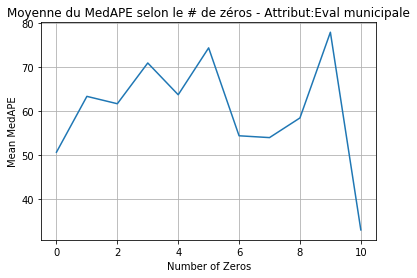

In [59]:
x1 = np.arange(0,11)
y1 = df_eval_tot_prime.groupby(['#_zeros']).MedAPE.mean()

fig1, ax1 = plt.subplots()
ax1.plot(x1, y1)

ax1.set(xlabel='Number of Zeros', ylabel='Mean MedAPE', title='Moyenne du MedAPE selon le # de zéros - Attribut:Eval municipale')
ax1.grid()

plt.show()

In [14]:
#create df
df_evalB = make_dataset(connection=['jlr_website', '1qaz2wsx', 'jlrorap1relv'], attribute='IMM_VALEUR_B', catbat=('2A', '3C'), region=(6,1), sampling_prob=None)

In [16]:
#clean df
df_evalB = df_evalB[(df_evalB['IMM_VALEUR_B'] >= 50000) & (df_evalB['IMM_VALEUR_B'] <= 2000000)]

In [18]:
temp_evalB_2A = df_evalB[df_evalB['CATBAT']=='2A']
pd.concat([pd.DataFrame(eval_metrics(temp_evalB_2A[(temp_evalB_2A['RA']==reg)], 'IMM_VALEUR_B', catbat='2A', region=reg), columns=['AVG_MAE', 'AVG_MAPE', 'AVG_MEDAPE', 'AVG_pctl_rank', 'AVG_#_zeros', 'AVG_#_NAN','catbat', 'region', '#_obs']) for reg in range(6,7)],
         ignore_index=False)

AVG_MAE AVG_MAPE AVG_MEDAPE AVG_pctl_rank AVG_#_zeros  \
IMM_VALEUR_B  195295.751   84.728     57.929        49.981        0.43   

             AVG_#_NAN catbat region   #_obs  
IMM_VALEUR_B      0.11     2A      6  158087